To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples (x₁, x₂), with x₁ in the interval from 0 to 2π and x₂ = sin(x₁), as illustrated in the following figure:

## import library

In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
torch.manual_seed(111)

## Preparing the Training Data

In [5]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

In [6]:
len(train_set)

1024

In [7]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

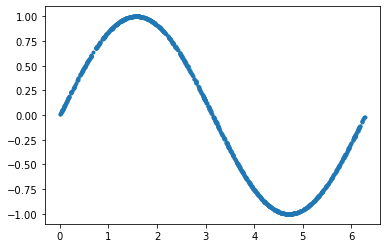

In [8]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [9]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## Implementing the Discriminator

* In PyTorch, the neural network models are represented by classes that inherit from nn.Module, 
* The discriminator is a model with a two-dimensional input and a one-dimensional output.
* It’ll receive a sample from the real data or from the generator and will provide the probability that the sample belongs to the real training data.

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

* use .__init__() to build the model. 
* First, you need to call super().__init__() to run .__init__() from nn.Module.
* The discriminator you’re using is an MLP neural network defined in a sequential way using nn.Sequential().
* Lines 5 and 6: The input is two-dimensional, and the first hidden layer is composed of 256 neurons with ReLU activation.
* Lines 8, 9, 11, and 12: The second and third hidden layers are composed of 128 and 64 neurons, respectively, with ReLU activation.
* Lines 14 and 15: The output is composed of a single neuron with sigmoidal activation to represent a probability.
* Lines 7, 10, and 13: After the first, second, and third hidden layers, you use dropout to avoid overfitting.

* After declaring the discriminator class, you should instantiate a Discriminator object:


In [15]:
discriminator = Discriminator()

## Implementing the Generator

* generator  model  takes samples from a latent space as its input and generates data resembling the data in the training set.
* In this case, it’s a model with a two-dimensional input, which will receive random points (z₁, z₂), and a two-dimensional output that must provide (x̃₁, x̃₂) points resembling those from the training data.
*  implementation is similar to what you did for the discriminator.

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

* Generator has two hidden layers with 16 and 32 neurons, both with ReLU activation, and 
* a linear activation layer with 2 neurons in the output.
* output will consist of a vector with two elements that can be any value ranging from negative infinity to infinity, which will represent (x̃₁, x̃₂).

## Training the Models

In [17]:
lr = 0.001
# num_epochs = 300
num_epochs = 5
loss_function = nn.BCELoss()  ## binary cross-entropy 

* binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task.
* It’s also suitable for training the generator since it feeds its output to the discriminator, which provides a binary observable output.
* PyTorch implements various weight update rules for model training in torch.optim.
* use the Adam algorithm to train the discriminator and generator models. 


In [18]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

 * need to implement a training loop in which training samples are fed to the models, and their weights are updated to minimize the loss function

In [19]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308737993240356
Epoch: 0 Loss G.: 1.7989580631256104
Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.907738447189331
Epoch: 20 Loss D.: 0.6200630068778992
Epoch: 20 Loss G.: 0.9532098770141602
Epoch: 30 Loss D.: 0.6286339163780212
Epoch: 30 Loss G.: 0.9837956428527832
Epoch: 40 Loss D.: 0.7340888381004333
Epoch: 40 Loss G.: 0.8471784591674805
Epoch: 50 Loss D.: 0.6541728377342224
Epoch: 50 Loss G.: 0.7553777098655701
Epoch: 60 Loss D.: 0.6983423829078674
Epoch: 60 Loss G.: 0.7128036618232727
Epoch: 70 Loss D.: 0.6756089329719543
Epoch: 70 Loss G.: 0.7302926778793335
Epoch: 80 Loss D.: 0.6582827568054199
Epoch: 80 Loss G.: 0.7085089683532715
Epoch: 90 Loss D.: 0.6711112260818481
Epoch: 90 Loss G.: 0.6342720985412598
Epoch: 100 Loss D.: 0.6668202877044678
Epoch: 100 Loss G.: 0.8669310808181763
Epoch: 110 Loss D.: 0.6317551136016846
Epoch: 110 Loss G.: 0.8675606846809387
Epoch: 120 Loss D.: 0.6917753219604492
Epoch: 120 Loss G.: 0.7788307666778564
Epoch: 1

* Line 2: You get the real samples of the current batch from the data loader and assign them to real_samples. Notice that the first dimension of the tensor has the number of elements equal to batch_size. This is the standard way of organizing data in PyTorch, with each line of the tensor representing one sample from the batch.

* Line 4: You use torch.ones() to create labels with the value 1 for the real samples, and then you assign the labels to real_samples_labels.

* Lines 5 and 6: You create the generated samples by storing random data in latent_space_samples, which you then feed to the generator to obtain generated_samples.

* Line 7: You use torch.zeros() to assign the value 0 to the labels for the generated samples, and then you store the labels in generated_samples_labels.

* Lines 8 to 11: You concatenate the real and generated samples and labels and store them in all_samples and all_samples_labels, which you’ll use to train the discriminator.

lines 14 to 19, you train the discriminator:
* Line 14: In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them. You do this using .zero_grad().

* Line 15: You calculate the output of the discriminator using the training data in all_samples.

* Lines 16 and 17: You calculate the loss function using the output from the model in output_discriminator and the labels in all_samples_labels.

* Line 18: You calculate the gradients to update the weights with loss_discriminator.backward().

* Line 19: You update the discriminator weights by calling optimizer_discriminator.step().

You train the generator in lines 25 to 32:

* Line 25: You clear the gradients with .zero_grad().

* Line 26: You feed the generator with latent_space_samples and store its output in generated_samples.

* Line 27: You feed the generator’s output into the discriminator and store its output in output_discriminator_generated, which you’ll use as the output of the whole model.

* Lines 28 to 30: You calculate the loss function using the output of the classification system stored in output_discriminator_generated and the labels in real_samples_labels, which are all equal to 1.

* Lines 31 and 32: You calculate the gradients and update the generator weights. Remember that when you trained the generator, you kept the discriminator weights frozen since you created optimizer_generator with its first argument equal to generator.parameters().

lines 35 to 37, you display the values of the discriminator and generator loss functions at the end of each ten epochs.

## Checking the Samples Generated by the GAN

after the training process is finished, you can get some random samples from the latent space and feed them to the generator to obtain some generated samples:

In [20]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)


* Then you can plot the generated samples and check if they resemble the training data.
* Before plotting the generated_samples data, you’ll need to use .detach() to return a tensor from the PyTorch computational graph, which you’ll then use to calculate the gradients

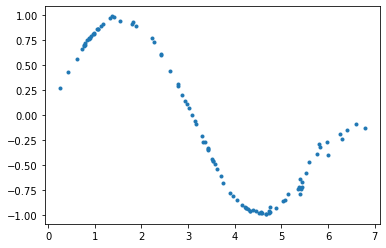

In [21]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")